From: Maria Jensen, Agronomy Lead — NorthStar Ag Retail
To: You (Data Science Consultant)
Subject: Did our fungicide & insecticide applications actually pay off?

Hi there,
We ran foliar fungicide and insecticide passes across portions of our growers’ corn fields this season, based on scouting and weather conditions around VT/R1. The team wants to know whether these applications truly increased yield, and under which conditions they were most effective.

Specifically, could you:

Estimate the causal effect (bu/acre and $/acre) of fungicide, insecticide, and both, versus no spray, while controlling for confounders like disease/pest pressure, humidity, recent rain, crop stage, soil (OM/CEC/pH), nitrogen rate, planting density, and prior yield history.

Identify heterogeneous treatment effects (HTE): when do these treatments pay off? e.g., high humidity + high disease pressure near R1, certain hybrids, certain soils, etc.

Provide prescriptive guidance for next season: a simple decision rule or dashboard indicating when we should spray (and when we should skip) to maximize profit per acre, net of product and application cost.

We’re not looking for simple correlations; please use an approach like propensity scores with doubly robust estimation, or Causal Forests, to correct for non-random treatment decisions. A clear ROI analysis ($/acre) by condition is essential for our grower meetings next month.

Thanks!
— Maria

## Identifiers & Structure
| Column        | Description                                            |
| :------------ | :----------------------------------------------------- |
| `season_year` | Crop year of observation (2024).                       |
| `field_id`    | Unique field identifier (e.g., F01–F20).               |
| `subfield_id` | Subfield/zone within field for finer spatial analysis. |
| `acres`       | Acreage represented by that subfield record.           |

## Genetics & Growth Stage
| Column                  | Description                                                                   |
| :---------------------- | :---------------------------------------------------------------------------- |
| `hybrid`                | Corn hybrid name or number planted in that subfield.                          |
| `hybrid_susceptibility` | Relative disease susceptibility score (0–1 scale, higher = more susceptible). |
| `crop_stage_window`     | Crop stage around potential treatment timing (V14, VT, R1, or R2).            |

## Disease & Pest Pressure
| Column                   | Description                                                |
| :----------------------- | :--------------------------------------------------------- |
| `disease_pressure_index` | Modeled disease infection potential (0–1 scale).           |
| `pest_pressure_index`    | Modeled insect pressure (0–1 scale).                       |
| `scouting_score_0_100`   | Field scout observation of pest/disease intensity (0–100). |

## Weather Around VT/R1

| Column            | Description                                              |
| :---------------- | :------------------------------------------------------- |
| `gdd_to_date`     | Growing degree days accumulated to the treatment window. |
| `precip_14d_in`   | Precipitation (inches) in the previous 14 days.          |
| `humidity_7d_pct` | Average relative humidity (%) in the previous 7 days.    |


# Soil & Topography

| Column         | Description                                                  |
| :------------- | :----------------------------------------------------------- |
| `soil_om_pct`  | Soil organic matter percentage (%).                          |
| `soil_cec_meq` | Cation exchange capacity (soil fertility measure, meq/100g). |
| `soil_ph`      | Soil pH level (acidity/alkalinity).                          |
| `slope_pct`    | Field slope (%), indicator of drainage/erosion potential.    |
| `elevation_m`  | Elevation above sea level (meters).                          |


# Historical Performance & Management

| Column                      | Description                                             |
| :-------------------------- | :------------------------------------------------------ |
| `prior_yield_3yr_avg_bu_ac` | 3-year average historical yield for that field (bu/ac). |
| `planting_date`             | Calendar date the crop was planted.                     |
| `planting_density_per_ac`   | Seeding rate (plants per acre).                         |
| `nitrogen_rate_lb_ac`       | Nitrogen fertilizer rate (lbs per acre).                |


# Treatment Variables

| Column                          | Description                                           |
| :------------------------------ | :---------------------------------------------------- |
| `treated_fungicide`             | 1 if fungicide was applied, else 0.                   |
| `treated_insecticide`           | 1 if insecticide was applied, else 0.                 |
| `treatment_timing_days_from_R1` | Days relative to the R1 stage (negative = before R1). |
| `treatment_cost_per_ac`         | Total cost of applied treatments ($/acre).            |


# Outcomes

| Column                    | Description                                                 |
| :------------------------ | :---------------------------------------------------------- |
| `yield_bu_ac`             | Final grain yield (bushels per acre).                       |
| `grain_moisture_pct`      | Grain moisture at harvest (%).                              |
| `harvest_date`            | Calendar date of harvest.                                   |
| `price_per_bu`            | Market corn price used for revenue calculations ($/bushel). |
| `observed_revenue_per_ac` | Realized revenue after treatment cost ($/acre).             |


# Derived / Analytical

| Column                              | Description                                                      |
| :---------------------------------- | :--------------------------------------------------------------- |
| `treatment_combo`                   | Combined treatment class: None, Fungicide, Insecticide, or Both. |
| *(optional)* `treatment_net_effect` | Within-field deviation in revenue from field mean ($/acre).      |


# Step 1 — Imports & Dataset Load

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / Modeling
from scipy import stats
import statsmodels.api as sm

# Display Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 150)
sns.set(style="whitegrid", palette="viridis")

# Load Dataset
df = pd.read_csv(r'C:\Users\wallj\DS_Projects\Datasets\pest_treatment_attribution.csv')

# Quick shape & preview
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
df.head()


Rows: 500, Columns: 31


,season_year,field_id,subfield_id,acres,hybrid,hybrid_susceptibility,crop_stage_window,disease_pressure_index,pest_pressure_index,scouting_score_0_100,gdd_to_date,precip_14d_in,humidity_7d_pct,soil_om_pct,soil_cec_meq,soil_ph,slope_pct,elevation_m,prior_yield_3yr_avg_bu_ac,planting_date,planting_density_per_ac,nitrogen_rate_lb_ac,treated_fungicide,treated_insecticide,treatment_timing_days_from_R1,treatment_cost_per_ac,yield_bu_ac,grain_moisture_pct,harvest_date,price_per_bu,observed_revenue_per_ac
0,2024,F01,F01_S25,7.8,Brevant-B07G,0.500,VT,0.234,0.000,10,1225,3.82,69,2.6,23.1,6.68,1.37,336.6,196.1,2024-05-01,32107,194,0,0,NaN,0.00,184.03,19.8,2024-10-15,4.75,874.13
1,2024,F01,F01_S24,7.9,Croplan-3899,0.382,VT,0.000,0.000,16,1126,3.44,55,2.6,23.1,6.68,1.37,336.6,196.1,2024-05-01,32107,194,1,0,0.0,15.96,196.11,20.0,2024-10-08,4.75,915.55
2,2024,F01,F01_S23,8.4,Croplan-3899,0.382,V14,0.221,0.151,32,1546,3.54,71,2.6,23.1,6.68,1.37,336.6,196.1,2024-05-01,32107,194,0,0,NaN,0.00,182.59,19.1,2024-10-17,4.75,867.33
3,2024,F01,F01_S22,11.3,HX-1132,0.430,R1,0.000,0.000,16,1218,1.37,63,2.6,23.1,6.68,1.37,336.6,196.1,2024-05-01,32107,194,0,0,NaN,0.00,197.78,16.3,2024-10-19,4.75,939.48
4,2024,F01,F01_S21,9.3,Brevant-B07G,0.500,R1,0.000,0.163,17,1432,3.51,81,2.6,23.1,6.68,1.37,336.6,196.1,2024-05-01,32107,194,0,0,NaN,0.00,183.21,20.9,2024-10-18,4.75,870.26


# Step 2 — Basic Info and Summary Stats

In [2]:
# Quick info
df.info()

# Numeric summary
df.describe().T.round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   season_year                    500 non-null    int64  
 1   field_id                       500 non-null    object 
 2   subfield_id                    500 non-null    object 
 3   acres                          500 non-null    float64
 4   hybrid                         500 non-null    object 
 5   hybrid_susceptibility          500 non-null    float64
 6   crop_stage_window              500 non-null    object 
 7   disease_pressure_index         500 non-null    float64
 8   pest_pressure_index            500 non-null    float64
 9   scouting_score_0_100           500 non-null    int64  
 10  gdd_to_date                    500 non-null    int64  
 11  precip_14d_in                  500 non-null    float64
 12  humidity_7d_pct                500 non-null    int

,count,mean,std,min,25%,50%,75%,max
season_year,500.0,2024.00,0.00,2024.00,2024.00,2024.00,2024.00,2024.00
acres,500.0,8.12,2.04,3.00,6.70,8.20,9.40,13.80
hybrid_susceptibility,500.0,0.53,0.12,0.38,0.43,0.50,0.56,0.75
disease_pressure_index,500.0,0.18,0.13,0.00,0.07,0.16,0.27,0.60
pest_pressure_index,500.0,0.18,0.12,0.00,0.10,0.18,0.26,0.51
scouting_score_0_100,500.0,22.66,11.97,0.00,15.00,22.00,31.00,61.00
gdd_to_date,500.0,1312.22,119.87,1000.00,1223.00,1313.00,1390.50,1600.00
precip_14d_in,500.0,2.83,1.14,0.00,2.07,2.85,3.65,6.03
humidity_7d_pct,500.0,71.50,7.79,45.00,66.00,71.00,77.00,94.00
soil_om_pct,500.0,3.93,0.83,2.22,3.58,4.16,4.48,5.10


# Missing Values Check

In [3]:
# Percentage of missing values per column
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0]

treatment_timing_days_from_R1    0.526
dtype: float64

# Treatment Overview

In [4]:
# Treatment flags
treat_cols = ["treated_fungicide", "treated_insecticide"]
treat_summary = df[treat_cols].apply(lambda x: x.value_counts(normalize=True)).T * 100
treat_summary.columns = ["% No", "% Yes"]
treat_summary.round(1)

,% No,% Yes
treated_fungicide,62.6,37.4
treated_insecticide,76.8,23.2


37.4% of our fields were treated w/fungicide

23.1% of our fields were treated w/insecticide

In [5]:
df["treatment_combo"] = (
    df["treated_fungicide"].astype(str) + df["treated_insecticide"].astype(str)
)
combo_map = {"00": "None", "10": "Fungicide Only", "01": "Insecticide Only", "11": "Both"}
df["treatment_combo"] = df["treatment_combo"].map(combo_map)

df["treatment_combo"].value_counts(normalize=True).mul(100).round(1)

treatment_combo
None                52.6
Fungicide Only      24.2
Both                13.2
Insecticide Only    10.0
Name: proportion, dtype: float64

52.6% of our fields were treated w/nothing

24.2% of our fields were treated w/fungicide only

13.2% of our fields were treated using both

10% of our fields were treated using insecticide

# Step 5 — Yield Distribution & Differences

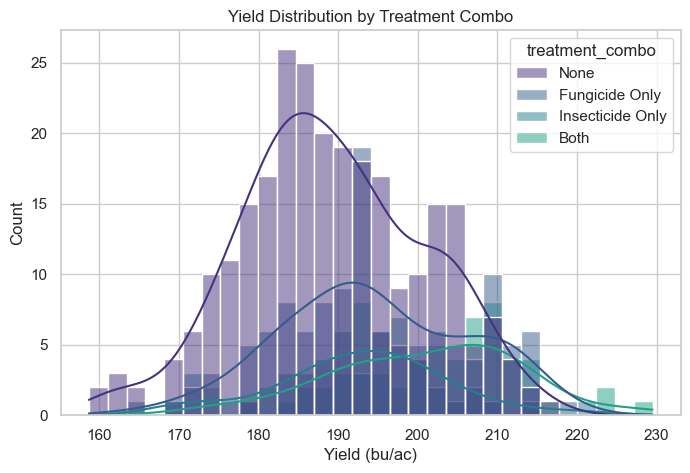

,mean,std,count
treatment_combo,,,
Both,201.00,11.78,66
Fungicide Only,194.57,11.73,121
Insecticide Only,193.02,10.67,50
None,189.23,11.36,263


In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df, x="yield_bu_ac", hue="treatment_combo", kde=True, bins=30)
plt.title("Yield Distribution by Treatment Combo")
plt.xlabel("Yield (bu/ac)")
plt.show()

# Mean yields by treatment
mean_yields = df.groupby("treatment_combo")["yield_bu_ac"].agg(["mean","std","count"])
mean_yields.round(2)

The distributions are appearing to favor both for yield, none appears to be the worst, insecticide appears to be similar to fungicide, but less confident, however fungicide is bimodal. They all seem a little bimodal.

# Step 6 — Relationships with Pressures & Yield

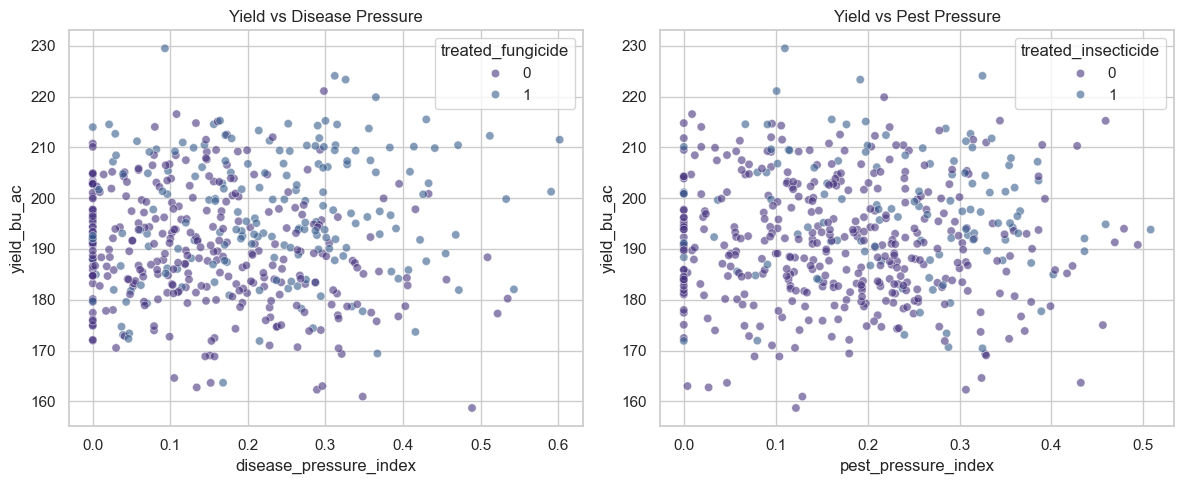

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(df, x="disease_pressure_index", y="yield_bu_ac", hue="treated_fungicide", alpha=0.6, ax=axes[0])
sns.scatterplot(df, x="pest_pressure_index", y="yield_bu_ac", hue="treated_insecticide", alpha=0.6, ax=axes[1])
axes[0].set_title("Yield vs Disease Pressure")
axes[1].set_title("Yield vs Pest Pressure")
plt.tight_layout()
plt.show()

I'm not seeing any relationships here - these are modeled disease & pest potential. We want to check this because Insecticide is sprayed to lower pest pressure, and fungicide is sprayed to avoid disease pressure.

# Step 7 — Profitability Snapshot

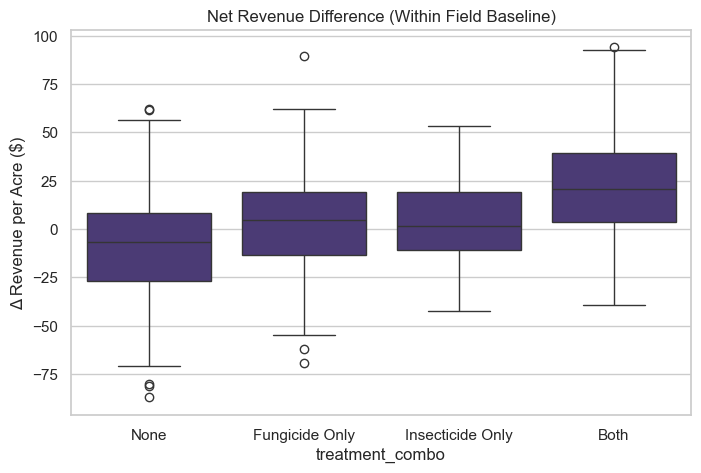

In [8]:
# Compute net revenue difference
df["treatment_net_effect"] = df["observed_revenue_per_ac"] - df.groupby("field_id")["observed_revenue_per_ac"].transform("mean")

plt.figure(figsize=(8,5))
sns.boxplot(df, x="treatment_combo", y="treatment_net_effect")
plt.title("Net Revenue Difference (Within Field Baseline)")
plt.ylabel("Δ Revenue per Acre ($)")
plt.show()

Revenue is following what we saw with the distribution graph around yield - both is winnign, insecticide similar to fungicide, but more confident, none not doing as well.

# Step 8 — Correlation Overview

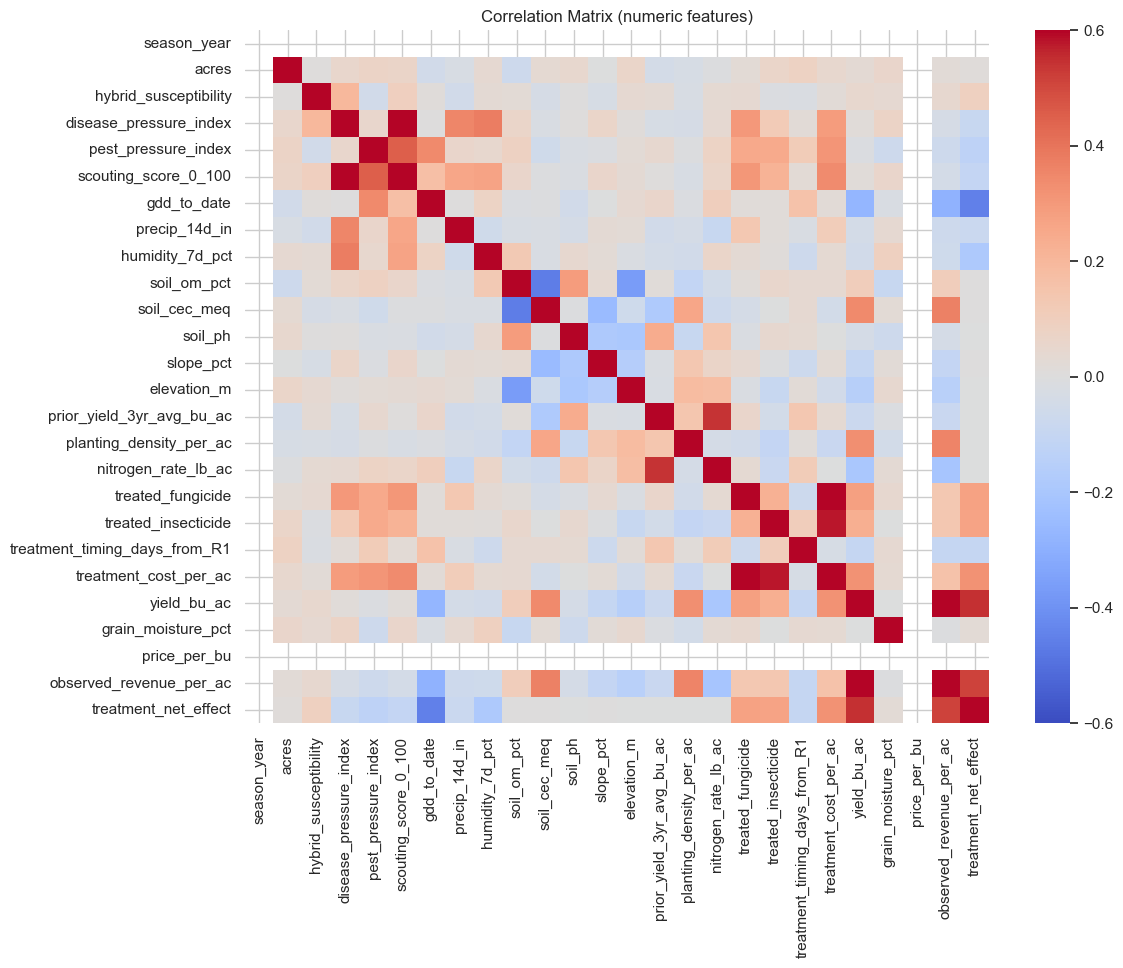

In [9]:
num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-0.6, vmax=0.6)
plt.title("Correlation Matrix (numeric features)")
plt.show()

I've never found these particularly useful

# Setup: treatment labels, features, and preprocessing

In [10]:
# --- Treatment label (4 arms) ---
def treatment_combo(row):
    if row["treated_fungicide"]==0 and row["treated_insecticide"]==0:
        return "None"
    if row["treated_fungicide"]==1 and row["treated_insecticide"]==0:
        return "Fungicide"
    if row["treated_fungicide"]==0 and row["treated_insecticide"]==1:
        return "Insecticide"
    return "Both"

df = df.copy()
df["treatment"] = df.apply(treatment_combo, axis=1)
treat_levels = ["None", "Fungicide", "Insecticide", "Both"] # setting up this list for use later

df['treatment'].value_counts()

treatment
None           263
Fungicide      121
Both            66
Insecticide     50
Name: count, dtype: int64

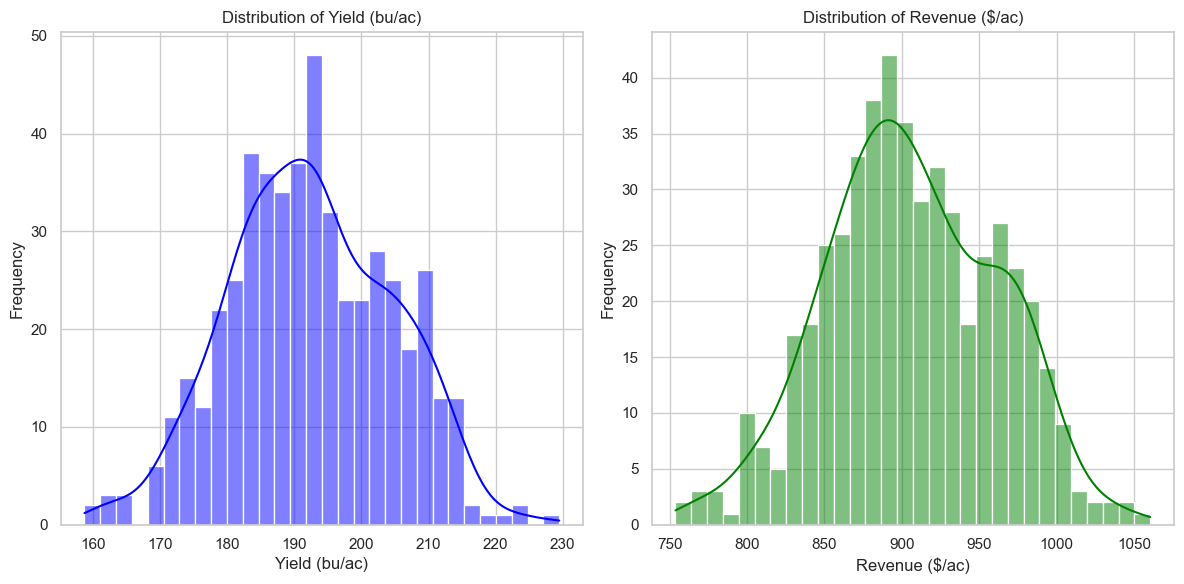

In [11]:
# --- Outcomes ---
y_yield = df["yield_bu_ac"].values
y_rev   = df["observed_revenue_per_ac"].values

import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions
plt.figure(figsize=(12, 6))

# Yield distribution
plt.subplot(1, 2, 1)
sns.histplot(y_yield, kde=True, bins=30, color="blue")
plt.title("Distribution of Yield (bu/ac)")
plt.xlabel("Yield (bu/ac)")
plt.ylabel("Frequency")

# Revenue distribution
plt.subplot(1, 2, 2)
sns.histplot(y_rev, kde=True, bins=30, color="green")
plt.title("Distribution of Revenue ($/ac)")
plt.xlabel("Revenue ($/ac)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
# --- Confounders (controls) ---
num_features = [
    "disease_pressure_index","pest_pressure_index","humidity_7d_pct","precip_14d_in",
    "soil_om_pct","soil_cec_meq","soil_ph","slope_pct","elevation_m",
    "prior_yield_3yr_avg_bu_ac","planting_density_per_ac","nitrogen_rate_lb_ac",
    "gdd_to_date","hybrid_susceptibility","acres"
]
cat_features = ["crop_stage_window"]  # stage around VT/R1

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocess = ColumnTransformer(
    [("num", "passthrough", num_features),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)]
)

# Multinomial propensity model (+ quick diagnostics)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

X = df[num_features + cat_features]
T = df["treatment"].values

prop_model = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs")) # multi_class="multinomial", - don't use this, it defaults to multinomial for >2 classes
])
prop_model.fit(X, T)

# Align predicted probabilities to treat_levels order
proba = prop_model.predict_proba(X)  # shape (n, K) in clf.classes_ order
classes = list(prop_model.named_steps["clf"].classes_)
order = [classes.index(k) for k in treat_levels]
P = proba[:, order]  # rows aligned to ["None","Fungicide","Insecticide","Both"]

# Quick diagnostics
ps_diag = pd.DataFrame({
    "Treatment": treat_levels,
    "Avg Propensity": P.mean(axis=0),
    "Min Propensity": P.min(axis=0)
})
ps_diag.round(3)


c:\Users\wallj\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Treatment,Avg Propensity,Min Propensity
0,None,0.526,0.413
1,Fungicide,0.243,0.181
2,Insecticide,0.100,0.044
3,Both,0.131,0.062


Build a propensity model for the treatment - likelihood to have received one of the 4 treatment combos. The purpose of these weights is to almost re-randomize the samples (but we'll verify it was done successfully in the next step)

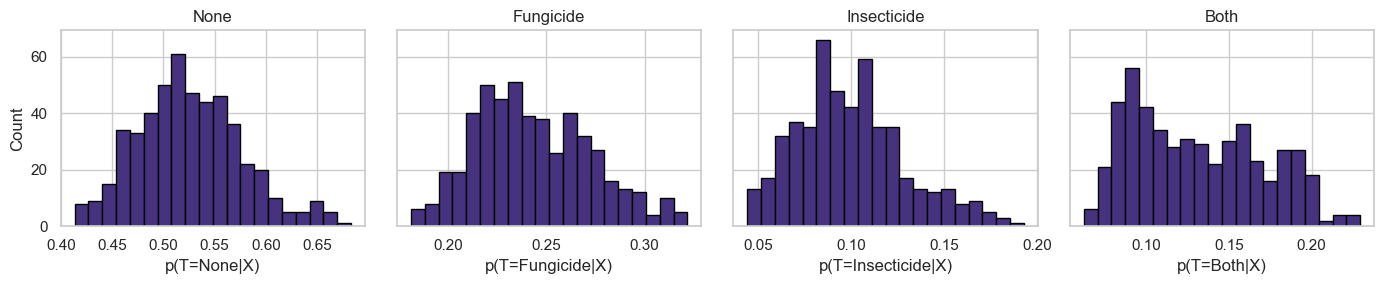

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,4, figsize=(14,3), sharey=True)
for j,k in enumerate(treat_levels):
    axes[j].hist(P[:, j], bins=20, edgecolor="k")
    axes[j].set_title(k)
    axes[j].set_xlabel("p(T={}|X)".format(k))
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()


We are trying to figure out the probability that each field was assigned a treatment, none, both, fungicide, or insecticide.

we’re using lbfgs to fit a multinomial logistic model that estimates how likely each subfield was to get each spray type given its conditions. those probabilities are the “weights” that let us unconfound our observational data and make our causal inference defensible.

# Balance diagnostics: standardized mean differences (SMD) under weights

What this does: computes SMD for each covariate, unweighted vs. stabilized IPW or overlap weights (your choice). Report a balance table; aim for |SMD| < 0.1 on average.

In [15]:
# --- Choose a weighting scheme for diagnostics ---
# Stabilized ATE weights for arm k: w_i = 1{T=k} * Pr(T=k) / p(T=k|X)
# Overlap weights for arm k: w_i = 1{T=k} * (1 - p(T=k|X))  (often better finite-sample stability)

scheme = "stabilized"  # or "overlap"

pi = P.mean(axis=0)  # marginal treatment probs
w = np.zeros_like(P)

for j,k in enumerate(treat_levels):
    if scheme == "stabilized":
        w[:, j] = (T == k).astype(float) * (pi[j] / np.clip(P[:, j], 1e-4, 1.0))
    elif scheme == "overlap":
        w[:, j] = (T == k).astype(float) * (1.0 - P[:, j])
    else:
        raise ValueError("Unknown weighting scheme")

# --- SMD helper ---
def smd_cont(x_t, x_c, w_t=None, w_c=None):
    # weighted means/vars
    if w_t is None: w_t = np.ones_like(x_t)
    if w_c is None: w_c = np.ones_like(x_c)
    mt = np.average(x_t, weights=w_t); mc = np.average(x_c, weights=w_c)
    vt = np.average((x_t-mt)**2, weights=w_t); vc = np.average((x_c-mc)**2, weights=w_c)
    sd = np.sqrt(0.5*(vt+vc) + 1e-9)
    return (mt - mc)/sd

# Compare each active arm vs. None
balance_rows = []
for arm in ["Fungicide","Insecticide","Both"]:
    j_t = treat_levels.index(arm)
    j_c = treat_levels.index("None")

    mask_t = (T==arm); mask_c = (T=="None")
    wt = w[mask_t, j_t]; wc = w[mask_c, j_c]

    for col in num_features:
        smd_w = smd_cont(df.loc[mask_t,col].values, df.loc[mask_c,col].values, wt, wc)
        # unweighted for reference:
        smd_unw = smd_cont(df.loc[mask_t,col].values, df.loc[mask_c,col].values)
        balance_rows.append({"Arm_vs_None": arm, "Covariate": col,
                             "SMD_unweighted": smd_unw, "SMD_weighted": smd_w})

balance_table = pd.DataFrame(balance_rows)
balance_table.sort_values(["Arm_vs_None","Covariate"]).round(3).head(30)


,Arm_vs_None,Covariate,SMD_unweighted,SMD_weighted
44,Both,acres,0.076,0.121
30,Both,disease_pressure_index,0.608,0.586
38,Both,elevation_m,-0.368,-0.150
42,Both,gdd_to_date,0.031,-0.045
32,Both,humidity_7d_pct,0.014,-0.087
43,Both,hybrid_susceptibility,-0.069,-0.029
41,Both,nitrogen_rate_lb_ac,-0.139,-0.104
31,Both,pest_pressure_index,0.861,0.825
40,Both,planting_density_per_ac,-0.339,-0.163
33,Both,precip_14d_in,0.180,0.216


# Outcome models per arm (T-learner style)

What this does: fits an outcome model for each arm using the same preprocessing. Start with a simple linear model + GBM; you can later add cross-fitting.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Just running gbm, but setting up for linear just in case we need interpretability!
def fit_outcome_models(y, base_model="gbm"):
    models = {}
    for k in treat_levels: # none, fungicide, insecticide, both
        mask = (T == k) # make sure to fit on observed outcomes only, T being the treatment assignment
        if base_model == "linear":
            mdl = Pipeline([("pre", preprocess),
                            ("reg", Ridge(alpha=1.0, random_state=42))])
        else:
            mdl = Pipeline([("pre", preprocess),
                            ("reg", GradientBoostingRegressor(random_state=42))])
        mdl.fit(X.loc[mask], y[mask])
        models[k] = mdl
    return models

# Fit outcome models for yield and revenue
models_yield = fit_outcome_models(y_yield, base_model="gbm")
models_rev   = fit_outcome_models(y_rev,   base_model="gbm")

# Predict m_k(X) for everyone
def predict_mu(models):
    mu = {}
    for k, mdl in models.items():
        mu[k] = mdl.predict(X) # for each treatment level, predict for all the other observations
    return mu

mu_yield = predict_mu(models_yield)  # dict: k -> np.array (n,)
mu_rev   = predict_mu(models_rev)

# Multi-arm AIPW (DR) ATEs vs None with 95% CIs

computes the doubly-robust ATE for each active arm vs None using the influence-function form (good SEs & CIs)

In [21]:
idx = {k:i for i,k in enumerate(treat_levels)}
idx

{'None': 0, 'Fungicide': 1, 'Insecticide': 2, 'Both': 3}

In [ ]:
def aiptw_ate_vs_none(mu_dict, y, P, T, treat_levels):
    """
    mu_dict: dict of {arm: mu_k(x_i)} predictions
    y: outcome vector
    P: propensity matrix aligned to treat_levels
    T: observed treatment labels
    returns: DataFrame with ATE, SE, 95% CI for each arm vs None
    """
    idx = {k:i for i,k in enumerate(treat_levels)} # {'None': 0, 'Fungicide': 1, 'Insecticide': 2, 'Both': 3}
    out = [] # empty list to store results
    n = len(y) # number of observations

    for arm in ["Fungicide","Insecticide","Both"]: # compare each active arm vs None
        e_k = np.clip(P[:, idx[arm]], 1e-4, 1.0) # give me everything for the arm probs, clip makes sure the values in the array are between 1e-4 and 1.0
        e_0 = np.clip(P[:, idx["None"]], 1e-4, 1.0) # give me everything for the none probs
        m_k = mu_dict[arm] # predicted outcomes for arm k
        m_0 = mu_dict["None"] # predicted outcomes for arm 0 (None)

        I_k = (T==arm).astype(float) # 
        I_0 = (T=="None").astype(float)

        # Influence function
        phi = (I_k*(y - m_k)/e_k) - (I_0*(y - m_0)/e_0) + (m_k - m_0)

        ate = float(phi.mean())
        se  = float(phi.std(ddof=1) / np.sqrt(n))
        lo, hi = ate - 1.96*se, ate + 1.96*se

        out.append({"Treatment": arm, "ATE": ate, "SE": se, "CI_low": lo, "CI_high": hi})

    return pd.DataFrame(out).sort_values("Treatment")

# Yield (bu/ac) ATEs
ates_yield = aiptw_ate_vs_none(mu_yield, y_yield, P, T, treat_levels)
ates_yield.round(2)

# Revenue ($/ac) ATEs
ates_rev = aiptw_ate_vs_none(mu_rev, y_rev, P, T, treat_levels)
ates_rev.round(2)


,Treatment,ATE,SE,CI_low,CI_high
2,Both,38.75,1.75,35.31,42.19
0,Fungicide,13.95,1.48,11.04,16.85
1,Insecticide,21.60,1.41,18.83,24.37


# Reporting tables (bu/ac & $/ac)

In [19]:
report = (ates_yield.rename(columns={"ATE":"ATE_bu_ac","SE":"SE_bu","CI_low":"CI_low_bu","CI_high":"CI_high_bu"})
          .merge(ates_rev[["Treatment","ATE"]].rename(columns={"ATE":"ATE_usd_ac"}),
                 on="Treatment", how="left")
         )
report.round(2)

,Treatment,ATE_bu_ac,SE_bu,CI_low_bu,CI_high_bu,ATE_usd_ac
0,Both,13.32,0.38,12.59,14.06,38.75
1,Fungicide,6.37,0.32,5.75,6.99,13.95
2,Insecticide,6.90,0.30,6.32,7.49,21.60
